In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.utils import resample
from sklearn.decomposition import PCA
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import plotly.express as px
import dash
from dash import dcc, html
from dash.dependencies import Input, Output

In [2]:
# Load the dataset
file_path = "ar41_for_ulb.csv"  
df = pd.read_csv(file_path, sep=';')
df = df.drop(columns=['Unnamed: 0'])
#limit to x% of the dataset
x = 10
df = df.sample(frac=x/100, random_state=1)

# Display the first few rows of the dataset
print("Dataset Overview:")
print(df.head())

# Display basic information about the dataset
print("\nDataset Information:")
print(df.info())

# Summary statistics for numerical columns
print("\nSummary Statistics:")
print(df.describe())

# Check for missing values
print("\nMissing Values:")
print(df.isnull().sum())

Dataset Overview:
          mapped_veh_id       timestamps_UTC        lat       lon  \
17334980          144.0  2023-02-27 07:35:50  51.055187  3.740974   
6347925           116.0  2023-06-22 13:22:51  51.037184  3.703916   
10145181          169.0  2023-07-29 20:14:27  51.063448  3.741056   
14164026          177.0  2023-07-22 20:37:16  51.088763  5.234605   
5372128           192.0  2023-03-15 13:31:57  51.088198  3.719310   

          RS_E_InAirTemp_PC1  RS_E_InAirTemp_PC2  RS_E_OilPress_PC1  \
17334980                11.0                13.0              224.0   
6347925                 35.0                35.0              227.0   
10145181                65.0                26.0                3.0   
14164026                35.0                37.0              200.0   
5372128                 47.0                38.0              179.0   

          RS_E_OilPress_PC2  RS_E_RPM_PC1  RS_E_RPM_PC2  RS_E_WatTemp_PC1  \
17334980              193.0         799.0         800.0        

In [3]:
# Explore unique values in categorical columns
print("\nUnique Values:")
for column in df.select_dtypes(include='object').columns:
    print(f"{column}: {df[column].unique()}")


Unique Values:
timestamps_UTC: ['2023-02-27 07:35:50' '2023-06-22 13:22:51' '2023-07-29 20:14:27' ...
 '2023-06-01 15:51:05' '2023-05-14 16:17:42' '2023-08-21 17:13:03']


IndexError: index 2 is out of bounds for axis 0 with size 2

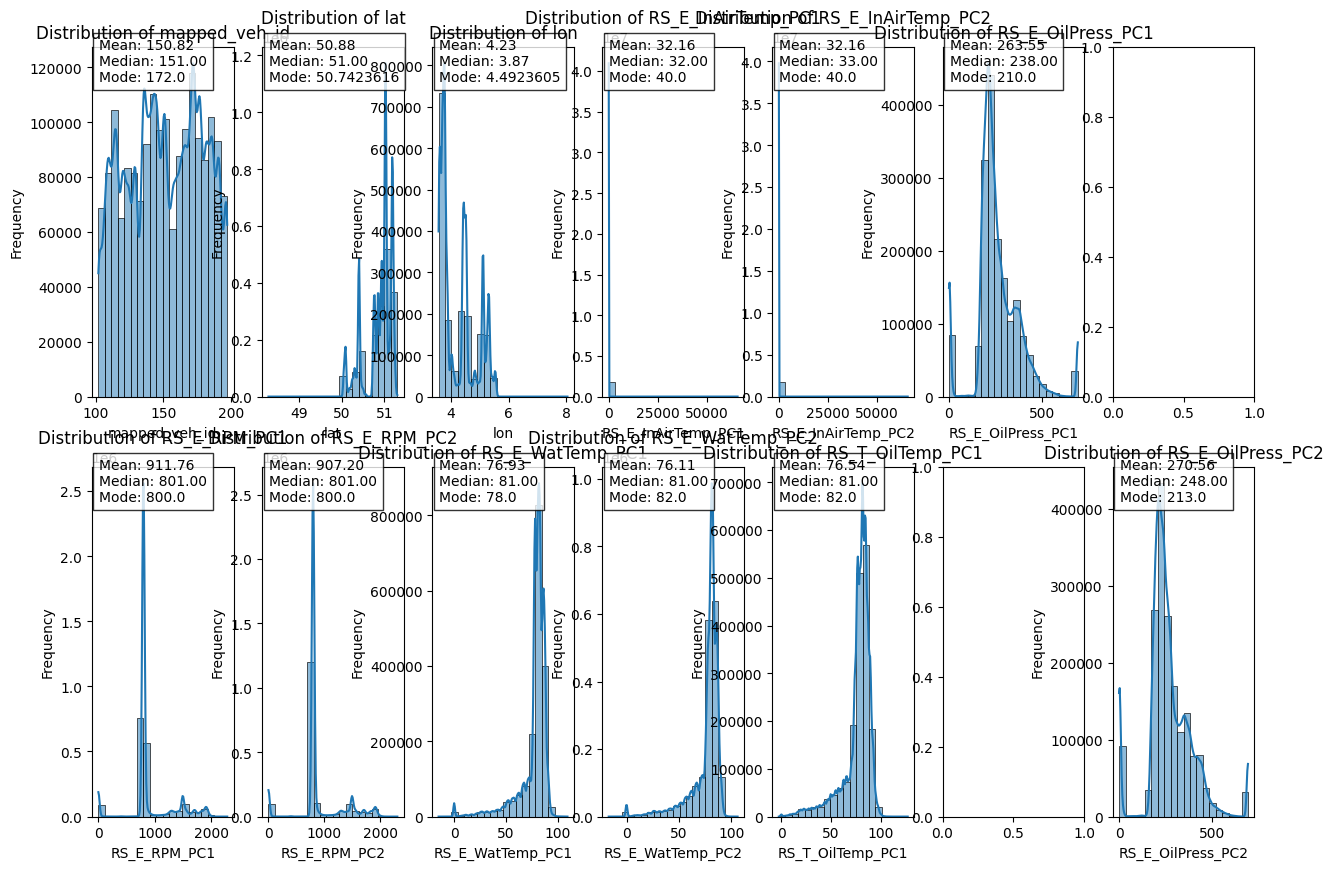

In [6]:
import statistics

# Exclude 'Unnamed' column if present
numerical_columns = df.select_dtypes(include='number').columns
numerical_columns = [col for col in numerical_columns if 'Unnamed' not in col]

# Visualize the distribution of numerical features
num_cols = len(numerical_columns)
fig, axes = plt.subplots(nrows=2, ncols=num_cols // 2 + num_cols % 2, figsize=(15, 10))

for i, column in enumerate(numerical_columns, 0):
    # Determine the current axis
    ax = axes[i // (num_cols // 2), i % (num_cols // 2 + num_cols % 2)]
    
    # Histogram
    sns.histplot(df[column], bins=20, kde=True, ax=ax)
    ax.set_xlabel(column)
    ax.set_ylabel('Frequency')

    # Summary statistics
    mean_value = df[column].mean()
    median_value = df[column].median()
    mode_value = statistics.mode(df[column])  # Using statistics module for mode

    summary_text = f"Mean: {mean_value:.2f}\nMedian: {median_value:.2f}\nMode: {mode_value}"
    ax.text(0.05, 0.9, summary_text, transform=ax.transAxes, bbox=dict(facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

# Correlation heatmap for numerical features
plt.figure(figsize=(12, 8))
sns.heatmap(df[numerical_columns].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()


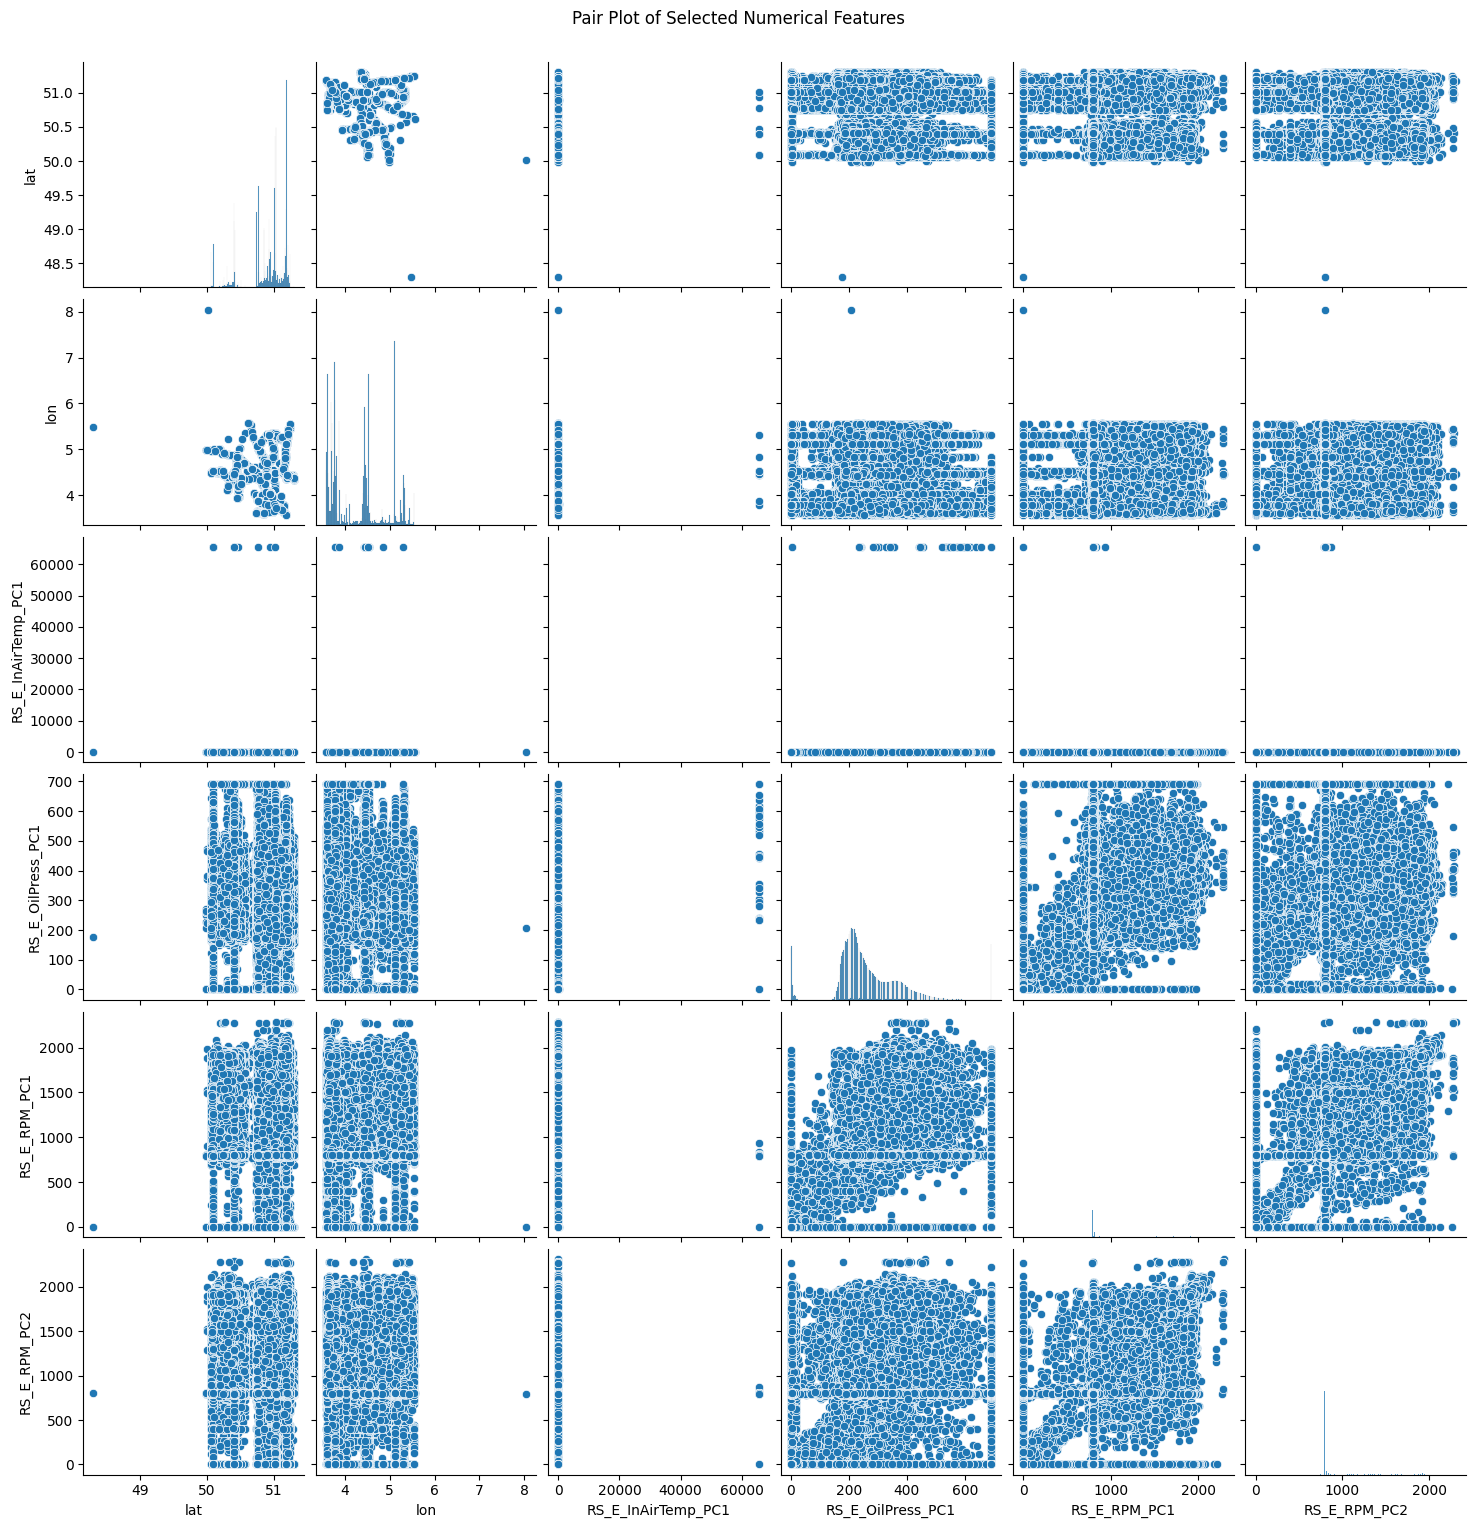

KeyboardInterrupt: 

In [7]:
# Pair plot for selected numerical features
numerical_features = ['lat', 'lon', 'RS_E_InAirTemp_PC1', 'RS_E_OilPress_PC1', 'RS_E_RPM_PC1', 'RS_E_RPM_PC2']
sns.pairplot(df[numerical_features])
plt.suptitle('Pair Plot of Selected Numerical Features', y=1.02)
plt.show()

# Time series plot for selected features
plt.figure(figsize=(14, 6))
plt.plot(df['timestamps_UTC'], df['RS_E_InAirTemp_PC1'], label='RS_E_InAirTemp_PC1')
plt.plot(df['timestamps_UTC'], df['RS_E_OilPress_PC1'], label='RS_E_OilPress_PC1')
plt.title('Time Series Plot of Selected Features')
plt.xlabel('Timestamp')
plt.ylabel('Values')
plt.legend()
plt.show()

In [10]:
# Convert 'timestamps_UTC' to datetime format
df['timestamps_UTC'] = pd.to_datetime(df['timestamps_UTC'])
X = df.drop(columns=['timestamps_UTC'])

# Handle missing values deleting rows with missing values
df.dropna(inplace=True)
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# Handling outliers using Z-score
from scipy.stats import zscore
z_scores = zscore(df['RS_E_InAirTemp_PC1'])
outliers = (z_scores > 3) | (z_scores < -3)
df = df[~outliers]

In [11]:
# Feature Engineering
df.loc[:, 'hour_of_day'] = df['timestamps_UTC'].dt.hour
df = df.interpolate(method='linear')
# Encoding categorical variables
label_encoder = LabelEncoder()
df.loc[:, 'mapped_veh_id'] = label_encoder.fit_transform(df['mapped_veh_id'])

# Scaling numerical features
scaler = StandardScaler()
numerical_columns = ['lat', 'lon', 'RS_E_InAirTemp_PC1', 'RS_E_OilPress_PC1', 'RS_E_RPM_PC1']
df.loc[:, numerical_columns] = scaler.fit_transform(df[numerical_columns])

In [12]:
# Extract time-related features from the timestamp
df['day_of_week'] = df['timestamps_UTC'].dt.dayofweek
df['day_of_month'] = df['timestamps_UTC'].dt.day
df['month'] = df['timestamps_UTC'].dt.month
df['year'] = df['timestamps_UTC'].dt.year

# Lag features for time series analysis
for feature in ['RS_E_InAirTemp_PC1', 'RS_E_OilPress_PC1', 'RS_E_RPM_PC1']:
    df[f'{feature}_lag_1'] = df[feature].shift(1)
    df[f'{feature}_rolling_mean'] = df[feature].rolling(window=3).mean()


In [13]:

# Use dimensionality reduction techniques if needed (e.g., PCA)
pca = PCA(n_components=2)


In [14]:
X = df.drop(['mapped_veh_id', 'timestamps_UTC'], axis=1)
# Pipeline for preprocessing and model training
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features)
    ])

# Parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_samples': ['auto', 100, 200],
    'contamination': [0.05, 0.1, 0.2]
}


In [15]:
# Grid search for Isolation Forest (this is supervised learning or not ? response: it is supervised learning)
""" y = df['mapped_veh_id']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
if_model = GridSearchCV(IsolationForest(random_state=42), param_grid=param_grid, scoring='roc_auc', cv=3)
if_model.fit(X_train, y_train)

# Best parameters for Isolation Forest
best_params_if = if_model.best_params_

# Predictions using the best Isolation Forest model
y_pred_if = if_model.predict(X_test)
y_pred_if = np.where(y_pred_if == -1, 1, 0)

# Evaluate Isolation Forest
print("\nIsolation Forest Metrics:")
print(confusion_matrix( y_pred_if))
print(classification_report( y_pred_if))
print("ROC AUC Score:", roc_auc_score( y_pred_if))

# Visualize feature importances from the best Isolation Forest model
feature_importances_if = if_model.best_estimator_.feature_importances_
features_if = X_train.columns
plt.figure(figsize=(10, 6))
plt.bar(features_if, feature_importances_if)
plt.title('Feature Importances - Isolation Forest')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.xticks(rotation=45)
plt.show() """

' y = df[\'mapped_veh_id\']\nX_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)\nif_model = GridSearchCV(IsolationForest(random_state=42), param_grid=param_grid, scoring=\'roc_auc\', cv=3)\nif_model.fit(X_train, y_train)\n\n# Best parameters for Isolation Forest\nbest_params_if = if_model.best_params_\n\n# Predictions using the best Isolation Forest model\ny_pred_if = if_model.predict(X_test)\ny_pred_if = np.where(y_pred_if == -1, 1, 0)\n\n# Evaluate Isolation Forest\nprint("\nIsolation Forest Metrics:")\nprint(confusion_matrix( y_pred_if))\nprint(classification_report( y_pred_if))\nprint("ROC AUC Score:", roc_auc_score( y_pred_if))\n\n# Visualize feature importances from the best Isolation Forest model\nfeature_importances_if = if_model.best_estimator_.feature_importances_\nfeatures_if = X_train.columns\nplt.figure(figsize=(10, 6))\nplt.bar(features_if, feature_importances_if)\nplt.title(\'Feature Importances - Isolation Forest\')\nplt.xlabel(\'F

In [16]:
# Grid search for Local Outlier Factor, local factor outlier is unsupervised learning because it is not using the label of the data or trainign set

# Apply Local Outlier Factor (LOF)
df = df.dropna()

imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

lof_model = LocalOutlierFactor(novelty=False, contamination=0.1)  # You can adjust contamination based on your dataset
lof_predictions = lof_model.fit_predict(X_imputed)

df.loc[:, 'lof_label'] = np.where(lof_predictions == -1, 1, 0)


# Select a subset of the dataframe with the features to plot
selected_features = df[['lon', 'lat', 'RS_E_InAirTemp_PC1', 'lof_label', 'mapped_veh_id', "RS_E_OilPress_PC1", "RS_E_RPM_PC1", "RS_E_InAirTemp_PC1_lag_1", "RS_E_InAirTemp_PC1_rolling_mean", "RS_E_OilPress_PC1_lag_1", "RS_E_OilPress_PC1_rolling_mean", "RS_E_RPM_PC1_lag_1", "RS_E_RPM_PC1_rolling_mean"]]
sns.pairplot(selected_features, hue='lof_label', palette='viridis')
plt.show()

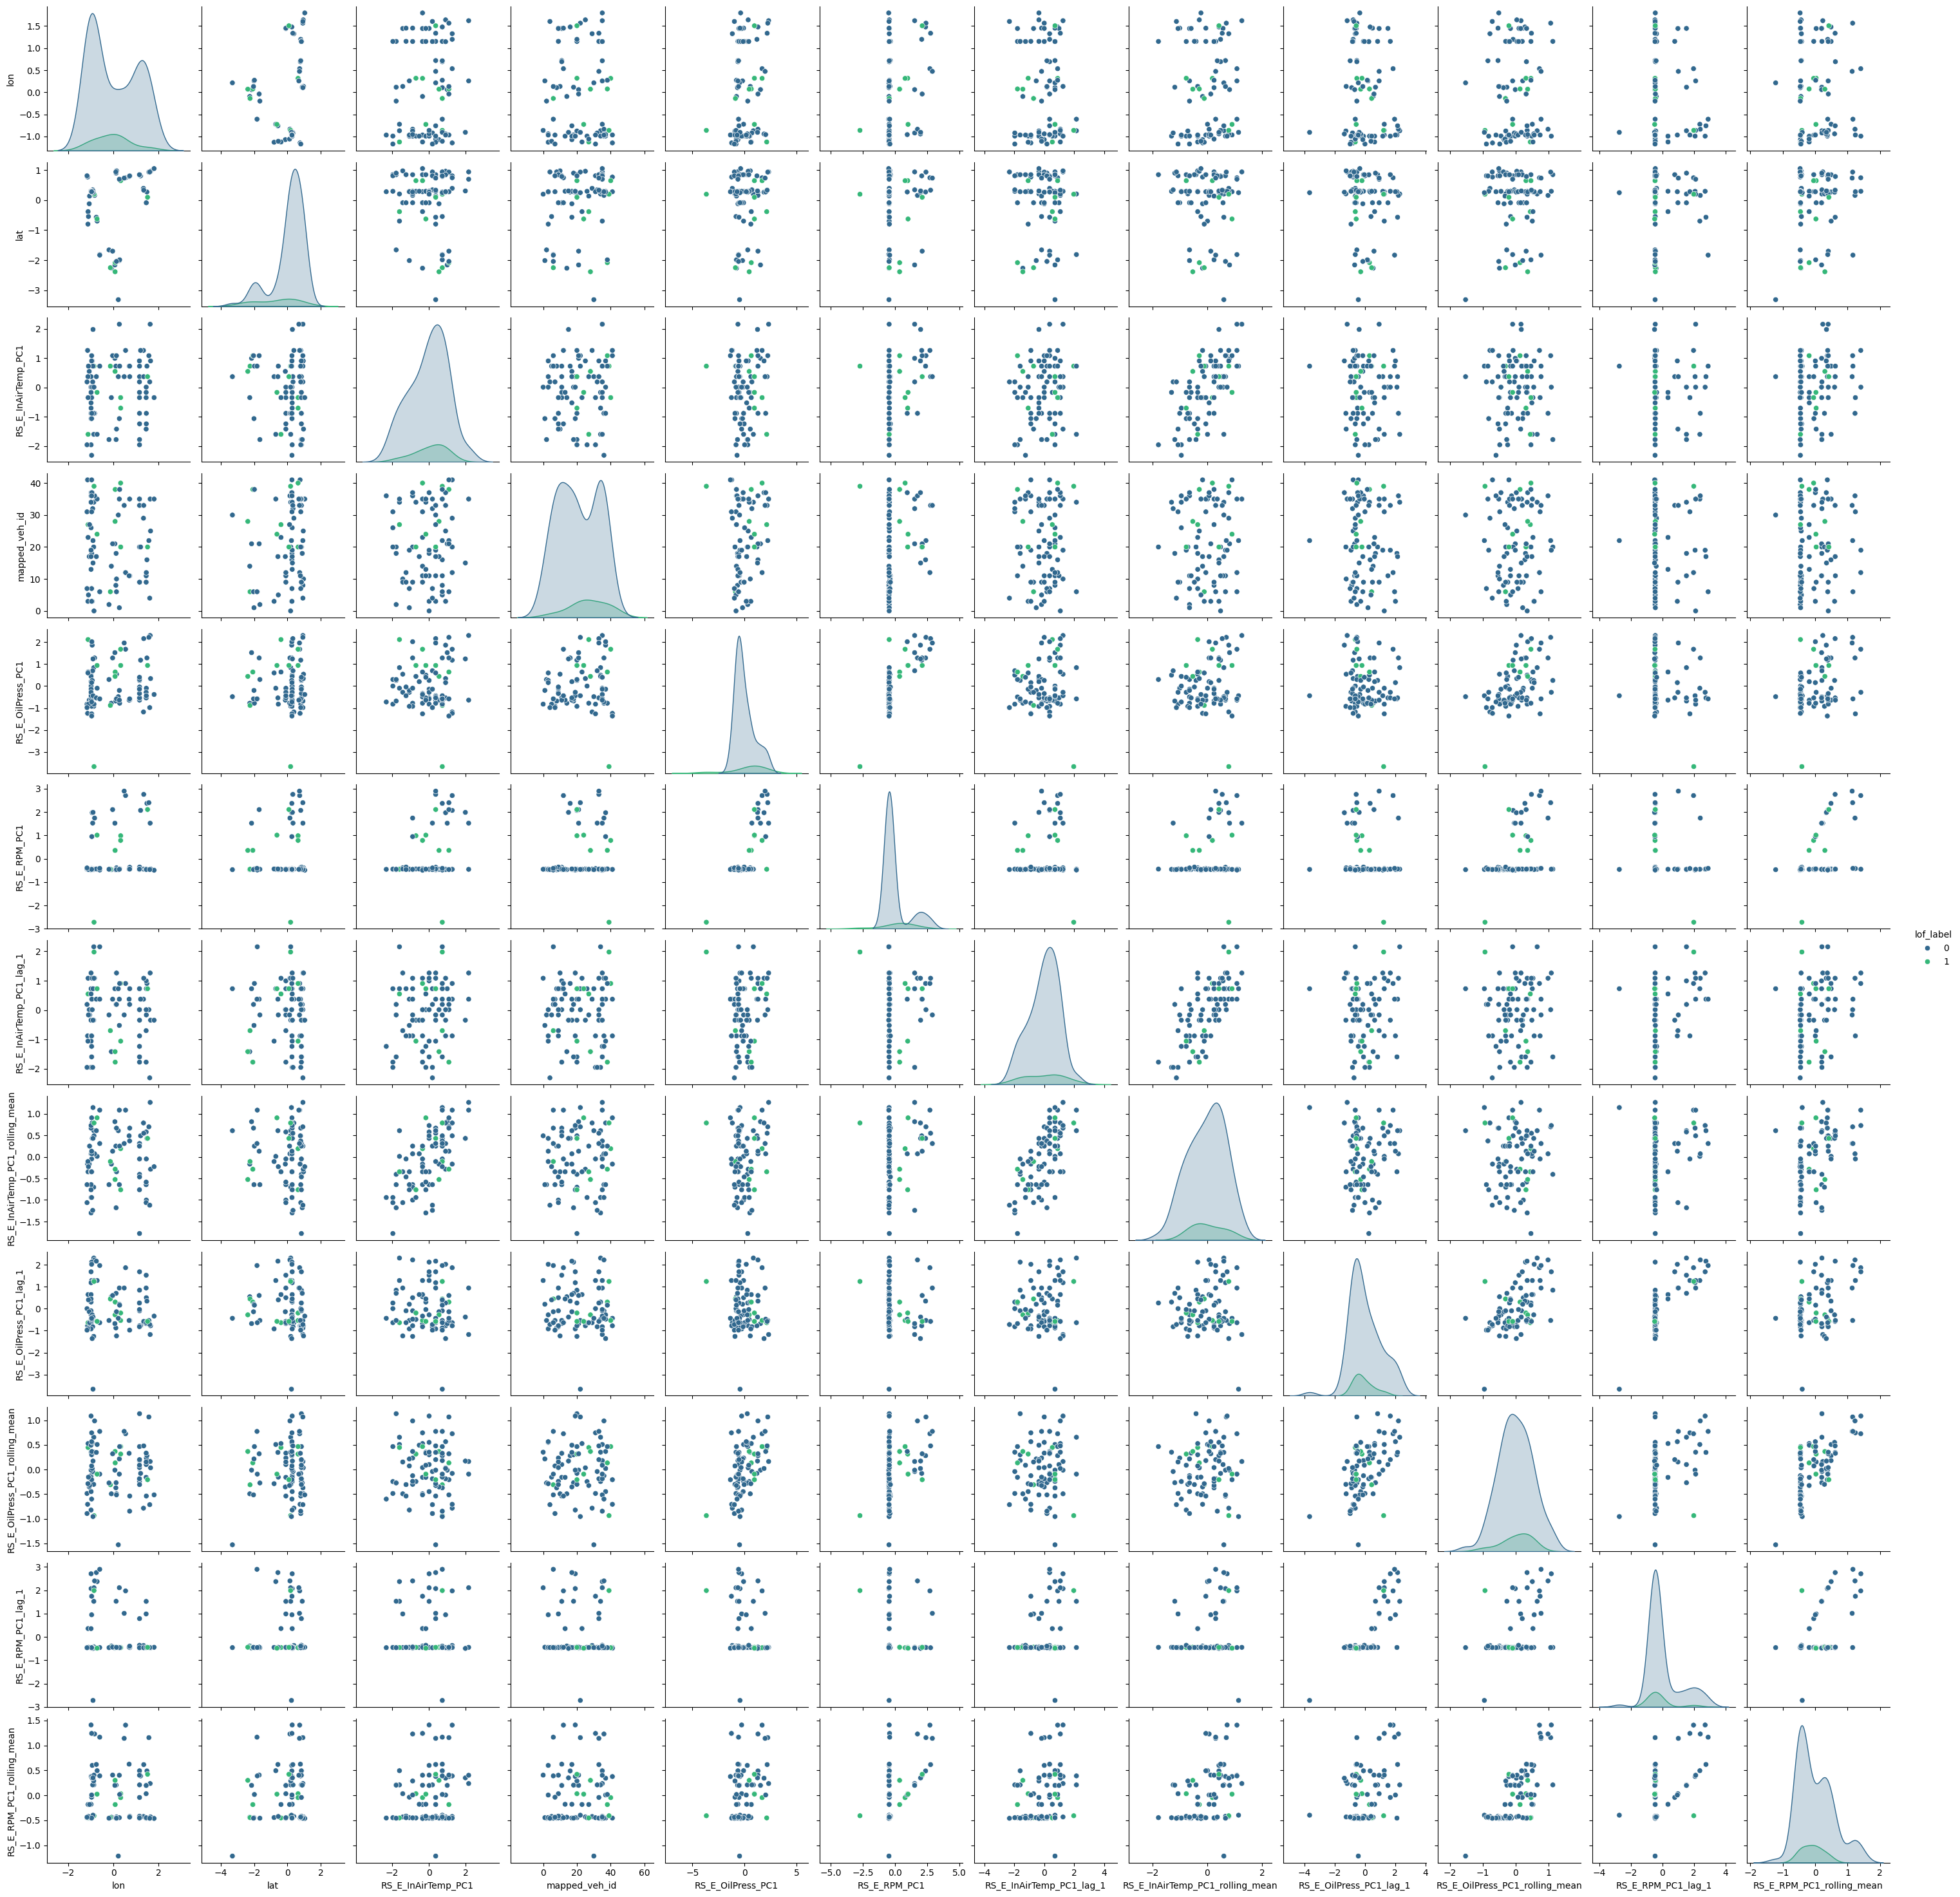

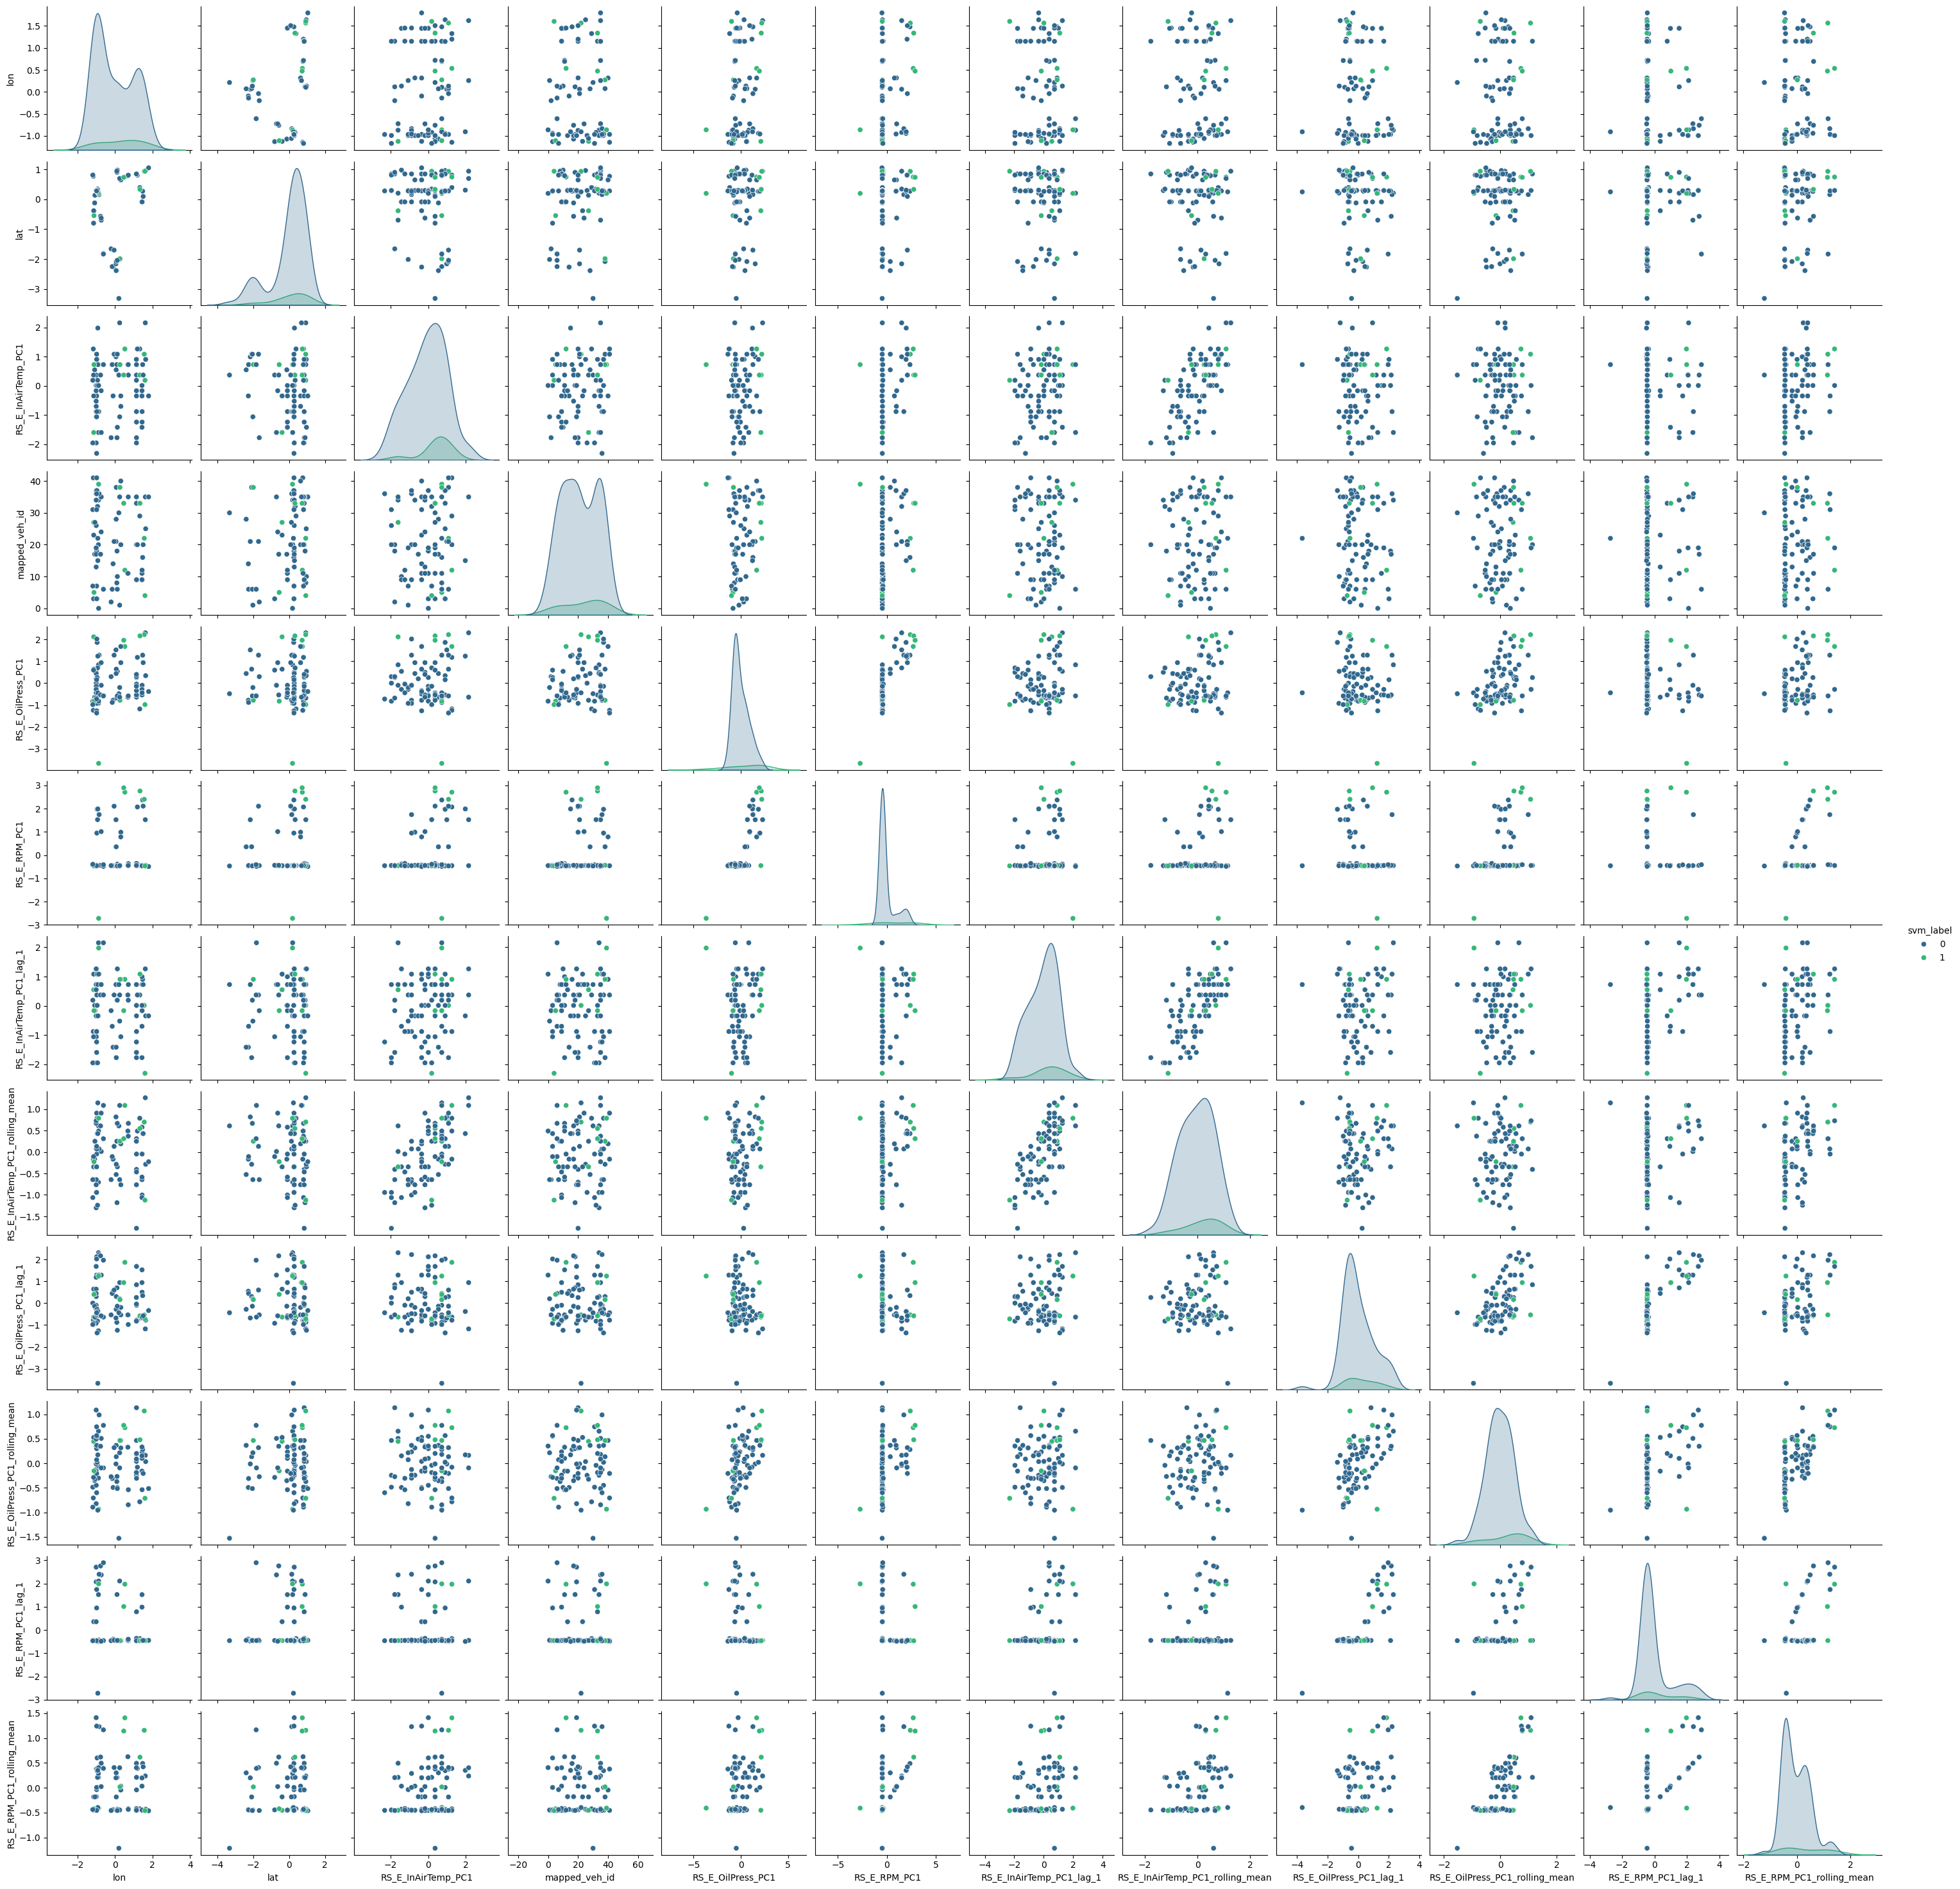

In [ ]:
X = df.drop(['timestamps_UTC'], axis=1)

svm_model = OneClassSVM(nu=0.1)  # You can adjust 'nu' based on your dataset
svm_predictions = svm_model.fit_predict(X)
df['svm_label'] = np.where(svm_predictions == -1, 1, 0)

# Visualize One-Class SVM results
# Select a subset of the dataframe with the features to plot
selected_features = df[['lon', 'lat', 'RS_E_InAirTemp_PC1', 'svm_label', 'mapped_veh_id', "RS_E_OilPress_PC1", "RS_E_RPM_PC1", "RS_E_InAirTemp_PC1_lag_1", "RS_E_InAirTemp_PC1_rolling_mean", "RS_E_OilPress_PC1_lag_1", "RS_E_OilPress_PC1_rolling_mean", "RS_E_RPM_PC1_lag_1", "RS_E_RPM_PC1_rolling_mean"]]
sns.pairplot(selected_features, hue='svm_label', palette='viridis')
plt.show()

Epoch 1/20

3/3 [==============================] - 2s 127ms/step - loss: 184894.0781 - val_loss: 183332.4688
Epoch 2/20
3/3 [==============================] - 0s 23ms/step - loss: 179269.3438 - val_loss: 178161.0625
Epoch 3/20
3/3 [==============================] - 0s 24ms/step - loss: 174110.7812 - val_loss: 172381.3750
Epoch 4/20
3/3 [==============================] - 0s 26ms/step - loss: 168274.5938 - val_loss: 165706.6250
Epoch 5/20
3/3 [==============================] - 0s 24ms/step - loss: 161613.2500 - val_loss: 157956.3594
Epoch 6/20
3/3 [==============================] - 0s 20ms/step - loss: 153745.3281 - val_loss: 148889.0625
Epoch 7/20
3/3 [==============================] - 0s 21ms/step - loss: 144763.1250 - val_loss: 138551.2188
Epoch 8/20
3/3 [==============================] - 0s 26ms/step - loss: 134501.9375 - val_loss: 127296.3750
Epoch 9/20
3/3 [==============================] - 0s 25ms/step - loss: 123339.3828 - val_loss: 115122.4609
Epoch 10/20
3/3 [==================

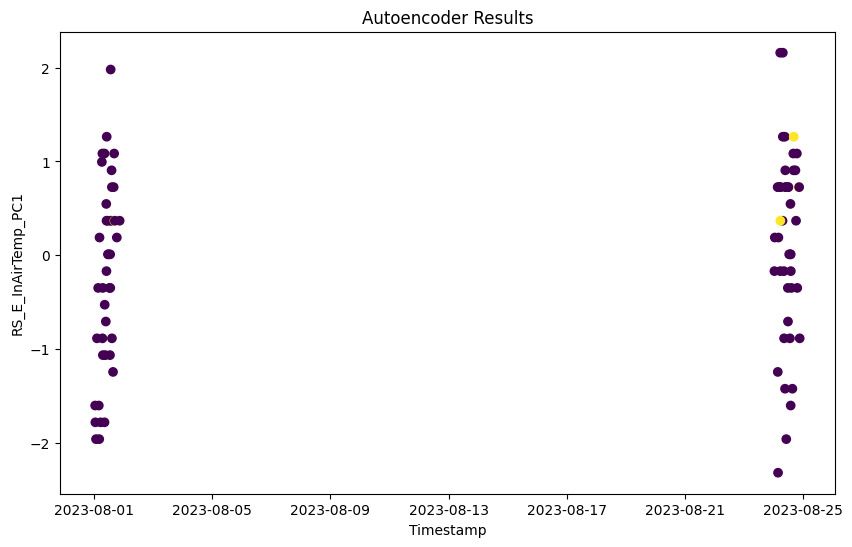

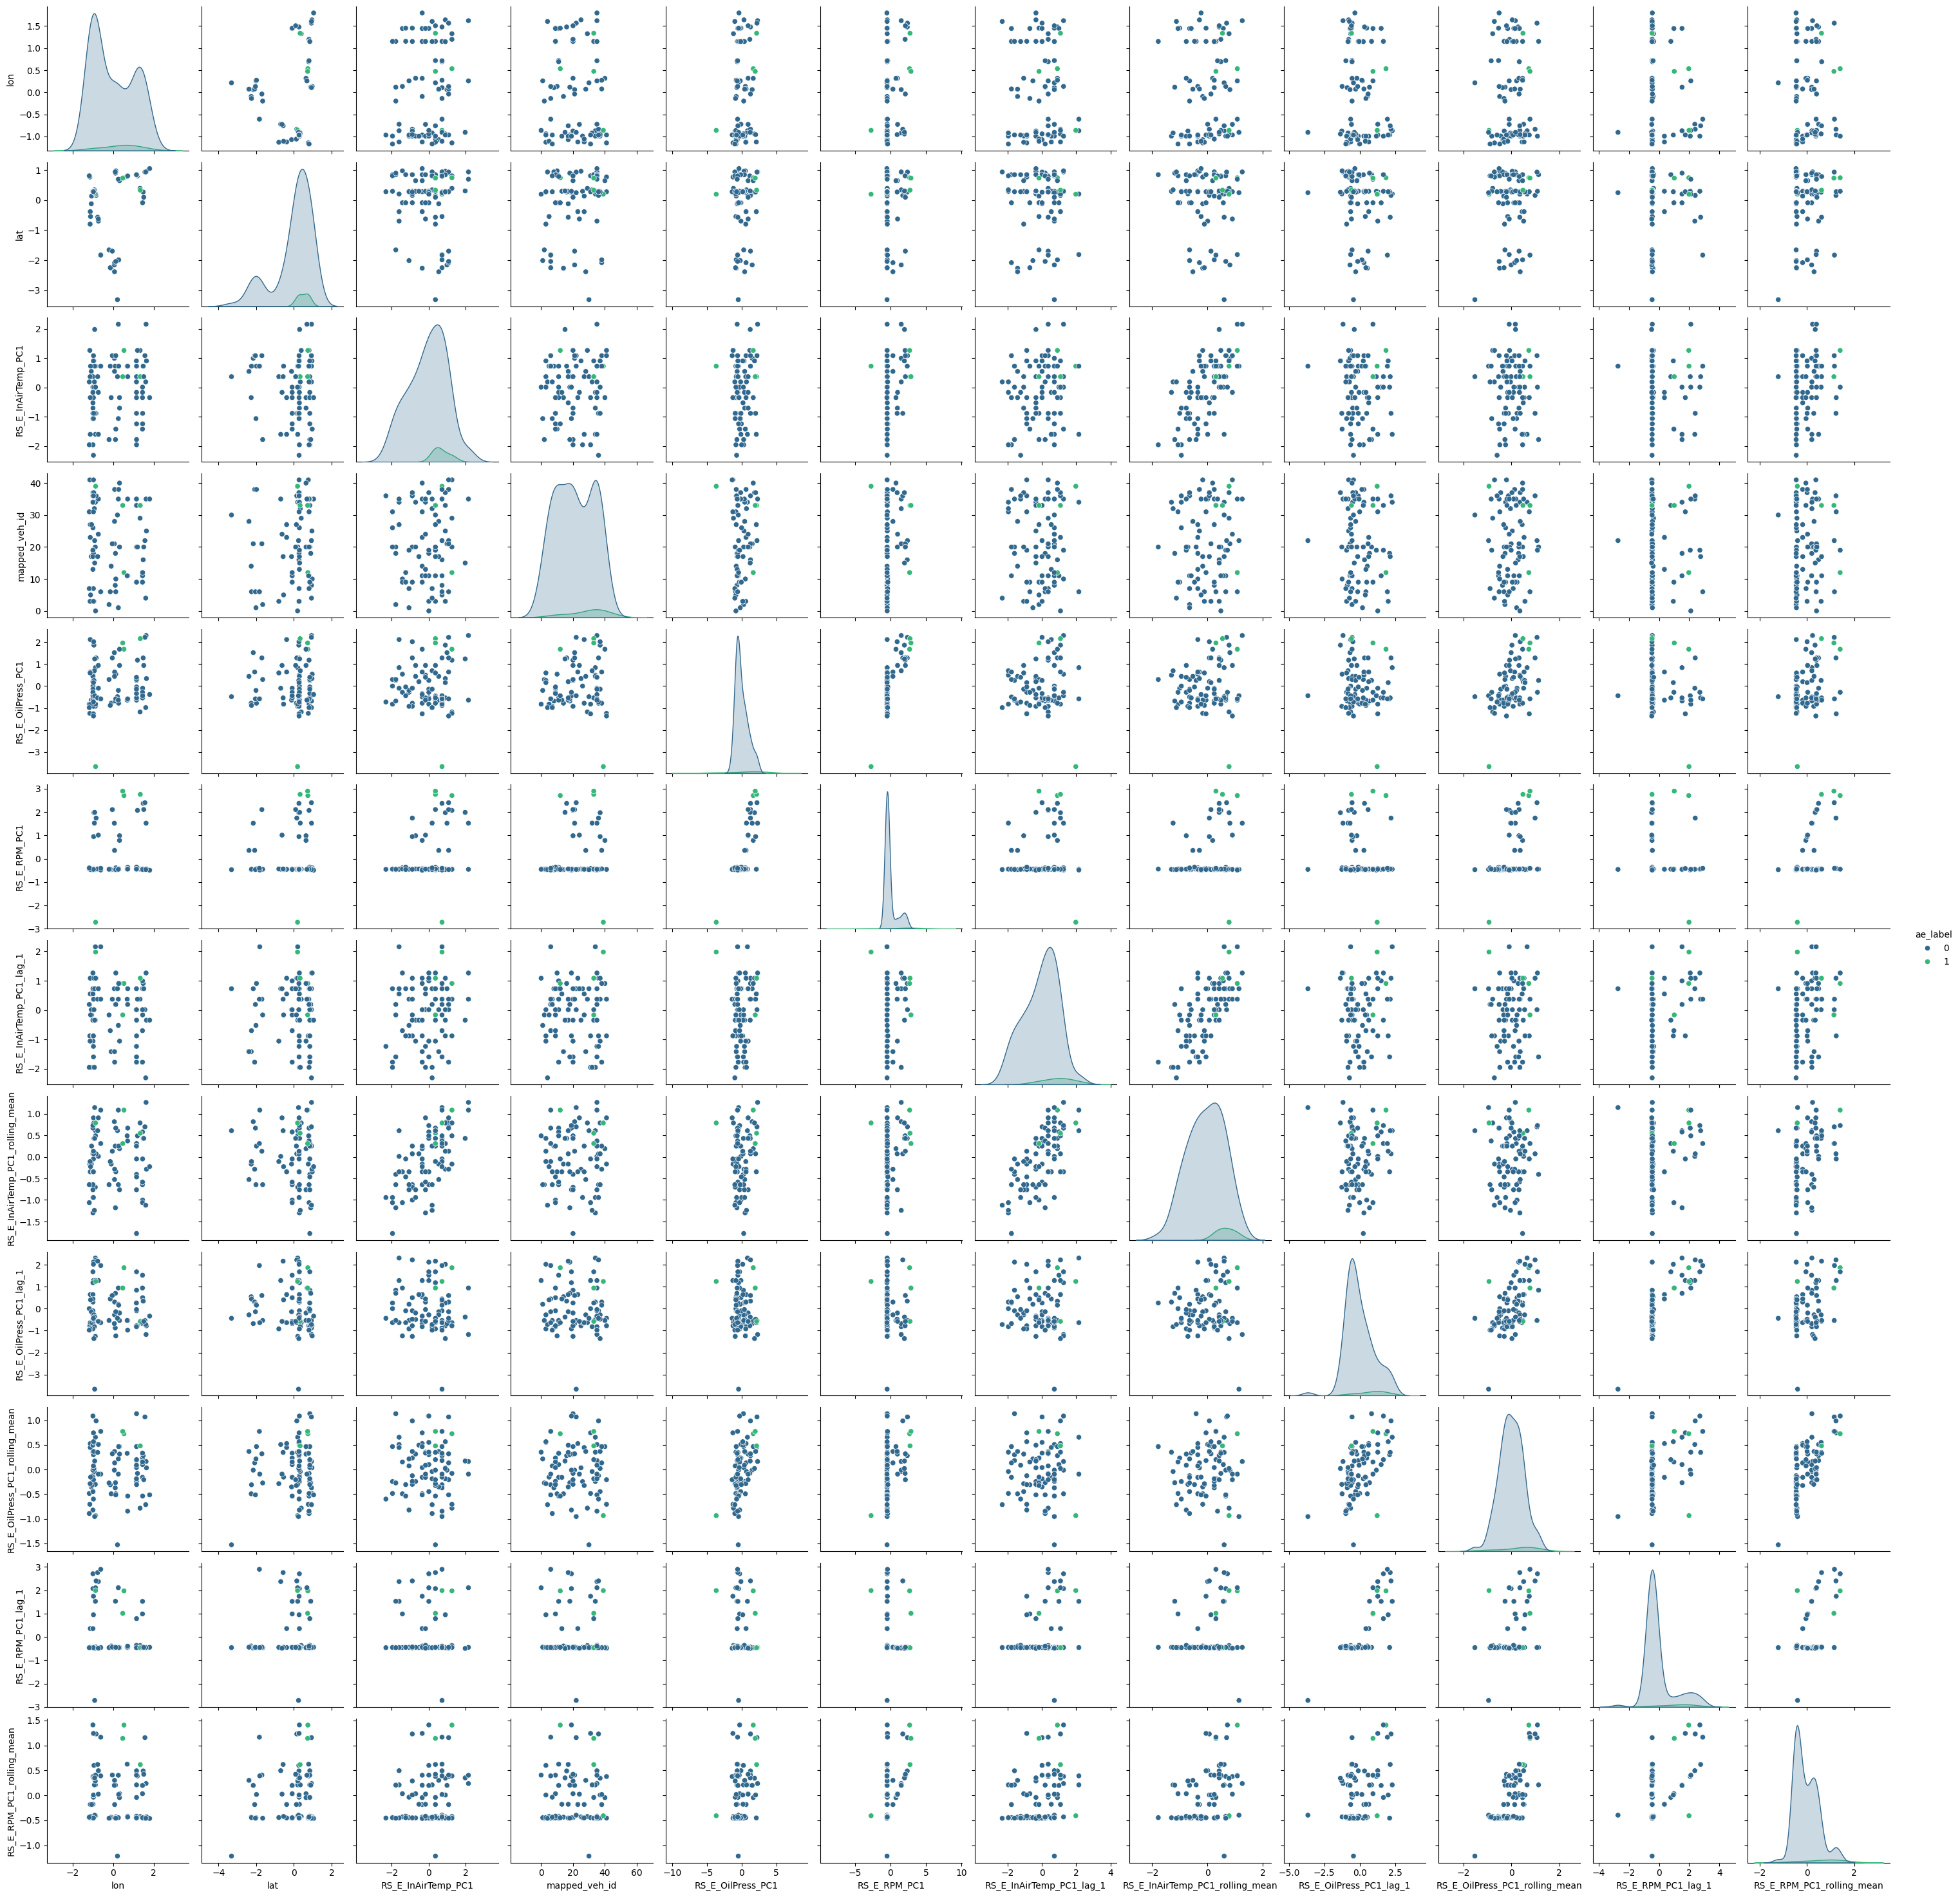

In [ ]:
# Neural Network Autoencoder
input_dim = df.shape[1] - 1  # Excluding the timestamp column
autoencoder_model = Sequential([
    Dense(32, activation='relu', input_dim=input_dim),
    Dense(16, activation='relu'),
    Dense(8, activation='relu'),
    Dense(16, activation='relu'),
    Dense(32, activation='relu'),
    Dense(input_dim, activation='linear')
])
autoencoder_model.compile(optimizer='adam', loss='mean_squared_error')
autoencoder_model.fit(df.drop(['timestamps_UTC'], axis=1), df.drop(['timestamps_UTC'], axis=1),
                      epochs=20, batch_size=32, shuffle=True, validation_split=0.2)

# Evaluate Autoencoder on the entire dataset
X_pred_ae = autoencoder_model.predict(df.drop(['timestamps_UTC'], axis=1))
mse_ae = np.mean(np.power(df.drop(['timestamps_UTC'], axis=1) - X_pred_ae, 2), axis=1)
df['ae_label'] = np.where(mse_ae > mse_ae.mean() + 3 * mse_ae.std(), 1, 0)

# Visualize Autoencoder results
plt.figure(figsize=(10, 6))
plt.scatter(df['timestamps_UTC'], df['RS_E_InAirTemp_PC1'], c=df['ae_label'], cmap='viridis')
plt.title('Autoencoder Results')
plt.xlabel('Timestamp')
plt.ylabel('RS_E_InAirTemp_PC1')
plt.show()

# Visualize Autoencoder results
# Select a subset of the dataframe with the features to plot
selected_features = df[['lon', 'lat', 'RS_E_InAirTemp_PC1', 'ae_label', 'mapped_veh_id', "RS_E_OilPress_PC1", "RS_E_RPM_PC1", "RS_E_InAirTemp_PC1_lag_1", "RS_E_InAirTemp_PC1_rolling_mean", "RS_E_OilPress_PC1_lag_1", "RS_E_OilPress_PC1_rolling_mean", "RS_E_RPM_PC1_lag_1", "RS_E_RPM_PC1_rolling_mean"]]
sns.pairplot(selected_features, hue='ae_label', palette='viridis')
plt.show()


In [ ]:
# Dashboard Development with Dash and Plotly
app = dash.Dash(__name__)

# Define layout and callback functions
app.layout = html.Div([
    html.H1("Anomaly Detection Dashboard"),

    dcc.Graph(
        id='time-series-plot',
        figure={
            'data': [
                {'x': df['timestamps_UTC'], 'y': df['RS_E_InAirTemp_PC1'], 'type': 'line', 'name': 'RS_E_InAirTemp_PC1'},
                {'x': df['timestamps_UTC'], 'y': df['RS_E_OilPress_PC1'], 'type': 'line', 'name': 'RS_E_OilPress_PC1'}
            ],
            'layout': {
                'title': 'Time Series Plot of Selected Features',
                'xaxis': {'title': 'Timestamp'},
                'yaxis': {'title': 'Values'},
            }
        }
    ),

    dcc.Graph(
        id='correlation-heatmap',
        figure={
            'data': [
                {
                    'z': df.corr().values,
                    'x': df.corr().columns,
                    'y': df.corr().index,
                    'type': 'heatmap',
                    'colorscale': 'Viridis'
                }
            ],
            'layout': {
                'title': 'Correlation Heatmap',
                'xaxis': {'title': 'Features'},
                'yaxis': {'title': 'Features'},
            }
        }
    ),

    dcc.Graph(
        id='pair-plot',
        figure={
            'data': [
                {'x': df['lon'], 'y': df['lat'], 'type': 'scatter', 'mode': 'markers'}
            ],
            'layout': {
                'title': 'Pair Plot of Selected Features',
                'xaxis': {'title': 'Longitude'},
                'yaxis': {'title': 'Latitude'},
            }
        }
    ),

    dcc.Graph(
        id='pair-plot-with-lof',
        figure={
            'data': [
                {'x': df['lon'], 'y': df['lat'], 'type': 'scatter', 'mode': 'markers', 'marker': {'color': df['lof_label']}}
            ],
            'layout': {
                'title': 'Pair Plot of Selected Features with LOF',
                'xaxis': {'title': 'Longitude'},
                'yaxis': {'title': 'Latitude'},
            }
        }
    ),

    dcc.Graph(
        id='pair-plot-with-svm',
        figure={
            'data': [
                {'x': df['lon'], 'y': df['lat'], 'type': 'scatter', 'mode': 'markers', 'marker': {'color': df['svm_label']}}
            ],
            'layout': {
                'title': 'Pair Plot of Selected Features with SVM',
                'xaxis': {'title': 'Longitude'},
                'yaxis': {'title': 'Latitude'},
            }
        }
    ),

    dcc.Graph(
        id='pair-plot-with-ae',
        figure={
            'data': [
                {'x': df['lon'], 'y': df['lat'], 'type': 'scatter', 'mode': 'markers', 'marker': {'color': df['ae_label']}}
            ],
            'layout': {
                'title': 'Pair Plot of Selected Features with Autoencoder',
                'xaxis': {'title': 'Longitude'},
                'yaxis': {'title': 'Latitude'},
            }
        }
    )
])


    

# Run the app
if __name__ == '__main__':
    app.run_server(debug=True)
